<a href="https://colab.research.google.com/github/gautamHCSCV/AI-ML/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A text classification model to detect whether the movie review is positive or negative.

Link of the dataset: https://www.kaggle.com/kazanova/sentiment140

We have 1.6 million samples from where we randomly select 25000 samples to traing and validate our models. Here we are loading the examples from our drives.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"
data = pd.read_csv(path,names = ['target','id','date','flag','user','text'],encoding='latin-1')
data = data.sample(25000)
data.head()

,target,id,date,flag,user,text
673135,0,2247394922,Fri Jun 19 19:01:58 PDT 2009,NO_QUERY,playtone,@djdeatheater They were sold out when I got th...
1518254,4,2175942086,Mon Jun 15 02:26:59 PDT 2009,NO_QUERY,ezanee,"@SazzyFalak You are most welcome, keep up with..."
171420,0,1963213044,Fri May 29 12:22:46 PDT 2009,NO_QUERY,sharpener,http://twitpic.com/678hs - 300 yd drive within...
17036,0,1556136798,Sat Apr 18 21:46:02 PDT 2009,NO_QUERY,k8phaup,@blanesaw ah so jealous if i didnt have so ma...
239761,0,1980690966,Sun May 31 07:25:32 PDT 2009,NO_QUERY,djstevehayward,@piyhda I miss you Hope to hear from you soo...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 673135 to 384521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  25000 non-null  int64 
 1   id      25000 non-null  int64 
 2   date    25000 non-null  object
 3   flag    25000 non-null  object
 4   user    25000 non-null  object
 5   text    25000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.3+ MB


In [5]:
data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [6]:
data.drop(["id","date","flag","user"],axis=1,inplace=True)

In [7]:
data.head()

,target,text
673135,0,@djdeatheater They were sold out when I got th...
1518254,4,"@SazzyFalak You are most welcome, keep up with..."
171420,0,http://twitpic.com/678hs - 300 yd drive within...
17036,0,@blanesaw ah so jealous if i didnt have so ma...
239761,0,@piyhda I miss you Hope to hear from you soo...


In [8]:
data["target"].value_counts()

0    12612
4    12388
Name: target, dtype: int64

Model Preprocessing

In [9]:
data["text"] = data["text"].astype(str)

In [10]:
data["text"] = data["text"].str.lower()
data.head()

,target,text
673135,0,@djdeatheater they were sold out when i got th...
1518254,4,"@sazzyfalak you are most welcome, keep up with..."
171420,0,http://twitpic.com/678hs - 300 yd drive within...
17036,0,@blanesaw ah so jealous if i didnt have so ma...
239761,0,@piyhda i miss you hope to hear from you soo...


In [11]:
import re
def rem_url(text):
    url_pat = re.compile(r'https?://\S+|www\.\S+')
    return url_pat.sub(r'', text)
data["text"] = data["text"].apply(lambda text: rem_url(text))
data.head()

,target,text
673135,0,@djdeatheater they were sold out when i got th...
1518254,4,"@sazzyfalak you are most welcome, keep up with..."
171420,0,- 300 yd drive within feet of the green. 2nd ...
17036,0,@blanesaw ah so jealous if i didnt have so ma...
239761,0,@piyhda i miss you hope to hear from you soo...


In [12]:
from bs4 import BeautifulSoup
def rem_html(text):
    return BeautifulSoup(text, "lxml").text
data["text"] = data["text"].apply(lambda text: rem_html(text))
data.head()

,target,text
673135,0,@djdeatheater they were sold out when i got th...
1518254,4,"@sazzyfalak you are most welcome, keep up with..."
171420,0,- 300 yd drive within feet of the green. 2nd t...
17036,0,@blanesaw ah so jealous if i didnt have so ma...
239761,0,@piyhda i miss you hope to hear from you soo...


In [13]:
def rem_username(text):
  return re.sub('@[^\s]+','',text)
data["text"] = data["text"].apply(lambda text: rem_username(text))
data.head()

,target,text
673135,0,they were sold out when i got there tonight o...
1518254,4,"you are most welcome, keep up with your quirk..."
171420,0,- 300 yd drive within feet of the green. 2nd t...
17036,0,ah so jealous if i didnt have so many tests ...
239761,0,i miss you hope to hear from you soon...


In [14]:
#@title Chat Words
words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [15]:
words_dict = {}
words_list = []
for single_line in words_str.split("\n"):
    if single_line != "":
        cw = single_line.split("=")[0]
        cw_exp = single_line.split("=")[1]
        words_list.append(cw)
        words_dict[cw] = cw_exp
words_list = set(words_list)

def words_conv(text):
    n_text = []
    for w in text.split():
        if w.upper() in words_list:
            n_text.append(words_dict[w.upper()])
        else:
            n_text.append(w)
    return " ".join(n_text)

data["text"] = data["text"].apply(lambda text: words_conv(text))
data.head()

,target,text
673135,0,they were sold out when i got there tonight on...
1518254,4,"you are most welcome, keep up with your quirky..."
171420,0,- 300 yd drive within feet of the green. 2nd t...
17036,0,ah so jealous if i didnt have so many tests th...
239761,0,i miss you hope to hear from you soon...


In [16]:
#@title Emoticons
emoticons = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [17]:
def con_emot(text):
    for emot in emoticons:
        text = re.sub(u'('+emot+')', "_".join(emoticons[emot].replace(",","").split()), text)
    return text
data["text"] = data["text"].apply(lambda text: con_emot(text))
data.head()

,target,text
673135,0,they were sold out when i got there tonight on...
1518254,4,"you are most welcome, keep up with your quirky..."
171420,0,- 300 yd drive within feet of the green. 2nd t...
17036,0,ah so jealous if i didnt have so many tests th...
239761,0,i miss you hope to hear from you soon...


In [18]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer as wnl
lemm = wnl()
def lemm_words(text):
    return " ".join([lemm.lemmatize(word) for word in text.split()])

data["text"] = data["text"].apply(lambda text: lemm_words(text))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,target,text
673135,0,they were sold out when i got there tonight on...
1518254,4,"you are most welcome, keep up with your quirky..."
171420,0,- 300 yd drive within foot of the green. 2nd t...
17036,0,ah so jealous if i didnt have so many test thi...
239761,0,i miss you hope to hear from you soon...


In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = set(stopwords.words('english'))
def rem_sw(text):
    return " ".join([word for word in str(text).split() if word not in sw])

data["text"] = data["text"].apply(lambda text: rem_sw(text))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,text
673135,0,sold got tonight game.
1518254,4,"welcome, keep quirky tweets."
171420,0,- 300 yd drive within foot green. 2nd time pla...
17036,0,ah jealous didnt many test week wouldve gone
239761,0,miss hope hear soon...


In [20]:
import string
punc = string.punctuation
def rem_punc(text):
    return text.translate(str.maketrans('', '', punc))
data["text"] = data["text"].apply(lambda text: rem_punc(text))
data.head()

,target,text
673135,0,sold got tonight game
1518254,4,welcome keep quirky tweets
171420,0,300 yd drive within foot green 2nd time playi...
17036,0,ah jealous didnt many test week wouldve gone
239761,0,miss hope hear soon


In [ ]:
#!pip install pyspellchecker

In [ ]:
"""from spellchecker import SpellChecker as SC
sc = SC()
def cor_spell(text):
    cor_text = []
    misspell_words = sc.unknown(text.split())
    for word in text.split():
        if word in misspell_words:
            cor_text.append(sc.correction(word))
        else:
            cor_text.append(word)
    return " ".join(cor_text)    
data["text"] = data["text"].apply(lambda text: cor_spell(text))
data.head()"""

'from spellchecker import SpellChecker as SC\nsc = SC()\ndef cor_spell(text):\n    cor_text = []\n    misspell_words = sc.unknown(text.split())\n    for word in text.split():\n        if word in misspell_words:\n            cor_text.append(sc.correction(word))\n        else:\n            cor_text.append(word)\n    return " ".join(cor_text)    \ndata["text"] = data["text"].apply(lambda text: cor_spell(text))\ndata.head()'

Splitting the model into training and testing datasets.

In [60]:
from sklearn.model_selection import train_test_split
for i in range(data.shape[0]):
    if data.iloc[i,0]==4:
        data.iloc[i,0] = 1
x_train,x_val,y_train,y_val = train_test_split(data.text,data.target,test_size=0.3,random_state=0)
train_data=pd.concat([x_train,y_train],axis=1)
train_data.reset_index(inplace=True, drop=True)
train_data.head()

,text,target
0,sorry shaelyn go dentist get new retainer ewwy...,0
1,suck doe get repetitive teacher really want ag...,0
2,oohhi thought country,1
3,woooooo guess completed gears im happy,1
4,oh hi sorry im messing around spymaster thing ...,0


Display of TDM matrix and TF-IDF matrix of different classes

You can skip the running of next 6 code blocks if you get a problem of RAM-overlaoading. You can directly start from model training and testing as they are handling tf-idf document conversions in their own pipelines.

In [ ]:
#@title TDM and TF-IDF matrixes
# for class 4 
from sklearn.feature_extraction.text import CountVectorizer

stmt_docs = [row['text'][:max(len(row['text']),500)] for index,row in data.iterrows() if row['target'] == 4]

vec_r = CountVectorizer()
X_r = vec_r.fit_transform(stmt_docs)
tdm_r = pd.DataFrame(X_r.toarray(), columns=vec_r.get_feature_names())

tdm_r

In [ ]:
#@title TDM and TF-IDF matrixes
# for class 0
from sklearn.feature_extraction.text import CountVectorizer

stmt_docs = [row['text'] for index,row in train_data.iterrows() if row['target'] == 0]

vec_f = CountVectorizer()
X_f = vec_f.fit_transform(stmt_docs)
tdm_f = pd.DataFrame(X_f.toarray(), columns=vec_f.get_feature_names())

tdm_f

In [ ]:
#@title TDM and TF-IDF matrixes
# for whole train data
from sklearn.feature_extraction.text import CountVectorizer

stmt_docs = [row['text'] for index,row in train_data.iterrows() ]

vec1 = CountVectorizer()
X = vec1.fit_transform(stmt_docs)
tdm = pd.DataFrame(X.toarray(), columns=vec1.get_feature_names())

tdm

In [ ]:
#@title TDM and TF-IDF matrixes
# for whole validation data
stmt_docs = list(x_val)

vec = CountVectorizer()
X = vec.fit_transform(stmt_docs)
tdm_test = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

tdm_test

In [ ]:
#@title TDM and TF-IDF matrixes
# TF-IDF Transformation of train data
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(tdm)
X_tfidf = tf_transformer.transform(tdm)
tfidf_train = pd.DataFrame(X_tfidf.toarray(), columns=vec1.get_feature_names())
tfidf_train.head()

In [ ]:
#@title TDM and TF-IDF matrixes
# TF-IDF Transformation of validation data
tf_transformer = TfidfTransformer(use_idf=False).fit(tdm_test)
X_tfidf = tf_transformer.transform(tdm_test)
tfidf_val = pd.DataFrame(X_tfidf.toarray(), columns=vec.get_feature_names())
tfidf_val.head()

Models training, testing and validaton

Starting with neural network model using tensorflow and keras

In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer


In [62]:
# Tokenezing the texts
tokenizer = Tokenizer(num_words = None, lower = True)
tokenizer.fit_on_texts(data['text'])
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_val)

In [63]:
# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_train = pad_sequences(train_sequences, maxlen = 10, truncating = 'pre', value = 0)
padded_test = pad_sequences(test_sequences, maxlen = 10, truncating = 'pre', value = 0)

In [64]:
import json
tokenizer_config = tokenizer.get_config()
index_word = json.loads(tokenizer_config['word_index'])
max_index_val = max(index_word.values())
max_index_val

26138

In [65]:
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dense

model = tf.keras.models.Sequential([
                                    Embedding(input_dim= max_index_val+1, output_dim= 64, mask_zero= True, input_length= 10),
                                    LSTM(64, return_sequences= True),
                                    LSTM(32),
                                    Dense(1, activation = 'sigmoid')
])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 64)            1672896   
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,718,369
Trainable params: 1,718,369
Non-trainable params: 0
_________________________________________________________________


In [68]:
his = model.fit(padded_train, y_train, epochs=6, validation_data=(padded_test, y_val), batch_size=16)

Epoch 1/6
1094/1094 [==============================] - 41s 37ms/step - loss: 0.1556 - accuracy: 0.9389 - val_loss: 1.0063 - val_accuracy: 0.6941
Epoch 2/6
1094/1094 [==============================] - 42s 38ms/step - loss: 0.1059 - accuracy: 0.9563 - val_loss: 1.0965 - val_accuracy: 0.6801
Epoch 3/6
1094/1094 [==============================] - 43s 39ms/step - loss: 0.0763 - accuracy: 0.9679 - val_loss: 1.4484 - val_accuracy: 0.6892
Epoch 4/6
1094/1094 [==============================] - 41s 38ms/step - loss: 0.0650 - accuracy: 0.9731 - val_loss: 1.4394 - val_accuracy: 0.6808
Epoch 5/6
1094/1094 [==============================] - 42s 38ms/step - loss: 0.0532 - accuracy: 0.9772 - val_loss: 1.6915 - val_accuracy: 0.6783
Epoch 6/6
1094/1094 [==============================] - 43s 40ms/step - loss: 0.0430 - accuracy: 0.9816 - val_loss: 1.7301 - val_accuracy: 0.6799


In [69]:
_, accuracy = model.evaluate(padded_test, y_val)
accuracy

235/235 [==============================] - 1s 5ms/step - loss: 1.7301 - accuracy: 0.6799


0.6798666715621948

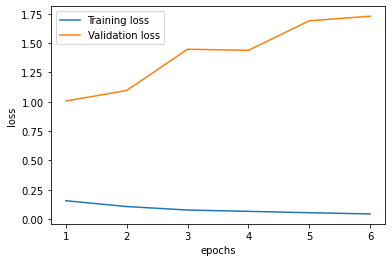

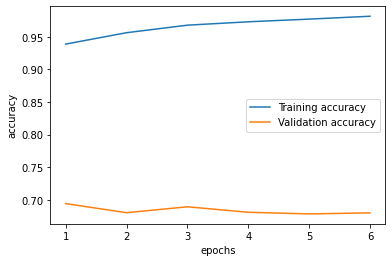

In [72]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,7)), his.history['loss'], label = 'Training loss')
plt.plot(list(range(1,7)), his.history['val_loss'], label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(list(range(1,7)), his.history['accuracy'], label = 'Training accuracy')
plt.plot(list(range(1,7)), his.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The tensorflow model really overfits. The trainning accuracy is above 98% but validation accuracy is close to 70% which shows overfitting.

Using sklearn models for training and testing.

In [22]:
#Using Multinomial model on raw data

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
text_clf.fit(x_train,y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [23]:
mult_score = text_clf.score(x_val,y_val)
mult_score

0.7396

In [24]:
from sklearn import metrics
predicted = text_clf.predict(x_val)
print(metrics.classification_report(y_val, predicted, target_names=['class - 0','class - 4']))

              precision    recall  f1-score   support

   class - 0       0.72      0.79      0.75      3772
   class - 4       0.76      0.69      0.72      3728

    accuracy                           0.74      7500
   macro avg       0.74      0.74      0.74      7500
weighted avg       0.74      0.74      0.74      7500



In [ ]:
# Using neural network to evaluate models
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)
mlp_model = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('mlp', mlp)])
mlp_model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
     

In [ ]:
mlp_score = mlp_model.score(x_val,y_val)
mlp_score

0.6733333333333333

In [ ]:
from sklearn import metrics
predicted = mlp_model.predict(x_val)
print(metrics.classification_report(y_val, predicted, target_names=['class - 0','class - 4']))

              precision    recall  f1-score   support

   class - 0       0.66      0.70      0.68      3678
   class - 4       0.69      0.65      0.67      3822

    accuracy                           0.67      7500
   macro avg       0.67      0.67      0.67      7500
weighted avg       0.67      0.67      0.67      7500



In [25]:
# Using pipeline of Perceptron model
from sklearn.linear_model import Perceptron
gauss = Perceptron(max_iter=600,eta0=0.01)
Perceptron_model = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('gauss', gauss)])
Perceptron_model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('gauss',
                 Perceptron(alpha=0.0001, class_weight=None,
                            early_stopping=False, eta0=0.01, fit_intercept=True,
          

In [26]:
perceptron_score = Perceptron_model.score(x_val,y_val)
perceptron_score

0.6884

In [27]:
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
Logistic_model = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('log', log)])
Logistic_model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('log',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [28]:
logistic_score = Logistic_model.score(x_val,y_val)
logistic_score

0.7437333333333334

In [29]:
Logistic_model.fit(x_train,y_train)
predicted = Logistic_model.predict(x_val)
print(metrics.classification_report(y_val, predicted, target_names=['class - 0','class - 4']))

              precision    recall  f1-score   support

   class - 0       0.75      0.74      0.74      3772
   class - 4       0.74      0.75      0.74      3728

    accuracy                           0.74      7500
   macro avg       0.74      0.74      0.74      7500
weighted avg       0.74      0.74      0.74      7500



In [30]:
# Using svc model
from sklearn.svm import SVC
svc = SVC()
svc_model = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('svc',svc)])
svc_model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [31]:
svc_score = svc_model.score(x_val,y_val)
svc_score

0.7470666666666667

In [32]:
predicted = svc_model.predict(x_val)
print(metrics.classification_report(y_val, predicted, target_names=['class - 0','class - 4']))

              precision    recall  f1-score   support

   class - 0       0.75      0.74      0.75      3772
   class - 4       0.74      0.75      0.75      3728

    accuracy                           0.75      7500
   macro avg       0.75      0.75      0.75      7500
weighted avg       0.75      0.75      0.75      7500



Applying feature reduction and retraining the models

In [ ]:
#@title 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
tdm = vect.fit_transform(data["text"]).toarray()
tdm.shape

(25000, 26155)

In [ ]:
#@title
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
tdm_new = SelectKBest(chi2, k=1000).fit_transform(tdm, data["target"])

In [ ]:
#@title
from sklearn.feature_extraction.text import TfidfTransformer as Tfidf
tfidf = Tfidf()
tfidf.fit(tdm_new)
tfidf_tdm_new = tfidf.transform(tdm_new).toarray()

In [ ]:
#@title
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(tfidf_tdm_new,data.target,test_size=0.3,random_state=0)

In [ ]:
#@title
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
model1 = MLPClassifier(alpha=0.001)
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#@title
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model2 = make_pipeline(StandardScaler(), SVC(probability=True, kernel="linear", class_weight="balanced"))
model2.fit(x_train, y_train)
y_pred2 = model2.predict(x_val)

In [ ]:
#@title
from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB()
model3.fit(x_train, y_train)
y_pred3 = model3.predict(x_val)

Display of variation of results due to dimension reduction

In [ ]:
#@title
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(x_train, y_train)
lda_x_train = lda.transform(x_train)
lda_x_val = lda.transform(x_val)

In [ ]:
#@title
model4 = MLPClassifier(alpha=0.001)
model4.fit(lda_x_train, y_train)
y_pred4 = model4.predict(lda_x_val)

In [ ]:
#@title
model5 = make_pipeline(StandardScaler(), SVC(probability=True, kernel="linear", class_weight="balanced",C=0.1))
model5.fit(lda_x_train, y_train)
y_pred5 = model5.predict(lda_x_val)

In [ ]:
#@title
model6 = GaussianNB()
model6.fit(lda_x_train, y_train)
y_pred6 = model6.predict(lda_x_val)

In [ ]:
#@title
acc2 = accuracy_score(y_val, y_pred2)
prec2 = precision_score(y_val, y_pred2, pos_label=4)
rec2 = recall_score(y_val, y_pred2, pos_label=4)
f1_score2 = f1_score(y_val, y_pred2, pos_label=4)

In [ ]:
#@title
acc3 = accuracy_score(y_val, y_pred3)
prec3 = precision_score(y_val, y_pred3, pos_label=4)
rec3 = recall_score(y_val, y_pred3, pos_label=4)
f1_score3 = f1_score(y_val, y_pred3, pos_label=4)

In [ ]:
#@title
acc4 = accuracy_score(y_val, y_pred4)
prec4 = precision_score(y_val, y_pred4, pos_label=4)
rec4 = recall_score(y_val, y_pred4, pos_label=4)
f1_score4 = f1_score(y_val, y_pred4, pos_label=4)

In [ ]:
#@title
acc5 = accuracy_score(y_val, y_pred5)
prec5 = precision_score(y_val, y_pred5, pos_label=4)
rec5 = recall_score(y_val, y_pred5, pos_label=4)
f1_score5 = f1_score(y_val, y_pred5, pos_label=4)

In [ ]:
#@title
acc6 = accuracy_score(y_val, y_pred6)
prec6 = precision_score(y_val, y_pred6, pos_label=4)
rec6 = recall_score(y_val, y_pred6, pos_label=4)
f1_score6 = f1_score(y_val, y_pred6, pos_label=4)

In [ ]:
# Before Reduction
comp = [[acc1,prec1,rec1,f1_score1],[acc2,prec2,rec2,f1_score2],[acc3,prec3,rec3,f1_score3]]
comp_df = pd.DataFrame(comp, columns=("Accuracy", "Precision", "Recall", "F1_score"), index=("MLP_Classifier","SVM","Naive_bayes"))
comp_df

,Accuracy,Precision,Recall,F1_score
MLP_Classifier,0.729467,0.711810,0.768717,0.739170
SVM,0.749333,0.731574,0.785561,0.757607
Naive_bayes,0.624533,0.864353,0.293048,0.437700


In [ ]:
# After Reduction
comp = [[acc4,prec4,rec4,f1_score4],[acc5,prec5,rec5,f1_score5],[acc6,prec6,rec6,f1_score6]]
comp_df = pd.DataFrame(comp, columns=("Accuracy", "Precision", "Recall", "F1_score"), index=("MLP_with_LDA","SVM_with_LDA","Naive_bayes_with_LDA"))
comp_df

,Accuracy,Precision,Recall,F1_score
MLP_with_LDA,0.758933,0.746680,0.781818,0.763845
SVM_with_LDA,0.760000,0.744702,0.789305,0.766355
Naive_bayes_with_LDA,0.759467,0.744815,0.787433,0.765532


In [ ]:
comp = [[acc1,prec1,rec1,f1_score1],[acc2,prec2,rec2,f1_score2],[acc3,prec3,rec3,f1_score3],[acc4,prec4,rec4,f1_score4],[acc5,prec5,rec5,f1_score5],[acc6,prec6,rec6,f1_score6]]
comp_df = pd.DataFrame(comp, columns=("Accuracy", "Precision", "Recall", "F1_score"), index=("MLP_Classifier","SVM","Naive_bayes","MLP_with_LDA","SVM_with_LDA","Naive_bayes_with_LDA"))
comp_df

,Accuracy,Precision,Recall,F1_score
MLP_Classifier,0.729467,0.711810,0.768717,0.739170
SVM,0.749333,0.731574,0.785561,0.757607
Naive_bayes,0.624533,0.864353,0.293048,0.437700
MLP_with_LDA,0.758933,0.746680,0.781818,0.763845
SVM_with_LDA,0.760000,0.744702,0.789305,0.766355
Naive_bayes_with_LDA,0.759467,0.744815,0.787433,0.765532


Group Members:\
1)Gautam Kumar(B19EE031)\
2)Chirag(B19CSE026)\
3)Ankur Borkar(B19CSE025)